<a href="https://colab.research.google.com/github/AdarshKammar/Python/blob/main/Sentiment_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 215s 583ms/step - accuracy: 0.6720 - loss: 0.5794 - val_accuracy: 0.6936 - val_loss: 0.5842
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 265s 593ms/step - accuracy: 0.8243 - loss: 0.4094 - val_accuracy: 0.8536 - val_loss: 0.3484
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 199s 566ms/step - accuracy: 0.9129 - loss: 0.2378 - val_accuracy: 0.8512 - val_loss: 0.3561
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 566ms/step - accuracy: 0.9375 - loss: 0.1829 - val_accuracy: 0.8612 - val_loss: 0.3927
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 567ms/step - accuracy: 0.9605 - loss: 0.1273 - val_accuracy: 0.8492 - val_loss: 0.3939
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - accuracy: 0.8235 - loss: 0.4798
Test Loss: 0.4845
Test Accuracy: 0.8208
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     12500
           1       0.84      0.80      0.82     12500

    accuracy         

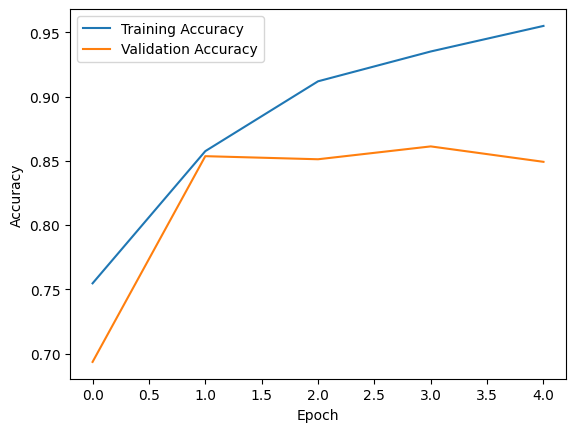

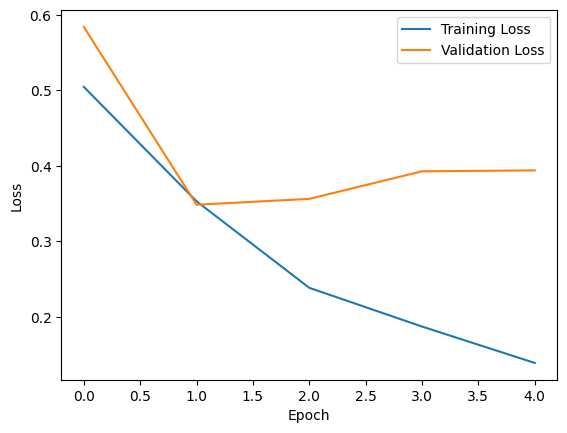

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Review: This movie was absolutely amazing! I loved it.
Predicted Sentiment: positive (Probability: 0.9899)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Review: This movie was terrible. I hated every minute of it.
Predicted Sentiment: negative (Probability: 0.0740)


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1. Dataset Preparation
# Load the IMDb movie review dataset
(train_data, test_data), info = tfds.load('imdb_reviews', with_info=True, split=('train', 'test'), as_supervised=True)

# 2. Text Preprocessing
# Define vocabulary size and maximum sequence length
VOCAB_SIZE = 10000  # Adjust as needed
MAX_LEN = 200  # Adjust as needed

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<oov>")

# Fit the tokenizer on the training data
texts_train = [text.numpy().decode('utf-8') for text, label in train_data] # Decode from bytes to string for tokenizer.fit_on_texts
tokenizer.fit_on_texts(texts_train)

def preprocess_text(text):
    tokens = tokenizer.texts_to_sequences([text])
    padded_tokens = pad_sequences(tokens, maxlen=MAX_LEN, padding='post', truncating='post')
    return padded_tokens[0] # Return the padded sequence

# Preprocess the data
train_data_processed = [(preprocess_text(text.numpy().decode('utf-8')), label.numpy()) for text, label in train_data]
test_data_processed = [(preprocess_text(text.numpy().decode('utf-8')), label.numpy()) for text, label in test_data]


# Separate features and labels
X_train = np.array([text for text, label in train_data_processed])
y_train = np.array([label for text, label in train_data_processed])
X_test = np.array([text for text, label in test_data_processed])
y_test = np.array([label for text, label in test_data_processed])



# 3. Build LSTM Model
model = Sequential([
    Embedding(VOCAB_SIZE, 64, input_length=MAX_LEN), # Input layer
    Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM
    Bidirectional(LSTM(32)), # Another LSTM layer
    Dropout(0.5), # Dropout for regularization
    Dense(1, activation='sigmoid') # Output layer (sigmoid for binary classification)
])

# 4. Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Train the LSTM Model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1) # Adjust epochs and batch size

# 6. Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype(int) # Get predictions (0 or 1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 7. Inference (Example)
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    padded_text = np.expand_dims(processed_text, axis=0) # Add batch dimension
    prediction = model.predict(padded_text)[0][0] # Get the probability
    sentiment = "positive" if prediction >= 0.5 else "negative"
    return sentiment, prediction

new_review = "This movie was absolutely amazing! I loved it."
sentiment, probability = predict_sentiment(new_review)
print(f"Review: {new_review}")
print(f"Predicted Sentiment: {sentiment} (Probability: {probability:.4f})")

new_review = "This movie was terrible. I hated every minute of it."
sentiment, probability = predict_sentiment(new_review)
print(f"Review: {new_review}")
print(f"Predicted Sentiment: {sentiment} (Probability: {probability:.4f})")